# Creation of transformed (FDA) patches dataset

Here is the code for the creation of multiple datasets to analyse the performances of AI models on the data transformed by Fourier Domain Adaptation. Three values of the hyperparameter defining the amount of style transfert will be tested: 0.01, 0.02, 0.05. The datasets will be under deeplake format.

## Requirements 


### Modules 


In [61]:
import deeplake
import numpy as np
import os
import uuid
from PIL import Image
import random
import matplotlib.pyplot as plt
from concurrent.futures import ProcessPoolExecutor
from functools import partial

### FDA functions

In [62]:
# ----------- Fourier Domain Adaptation (with clipping + uint8 conversion) -------------
def low_freq_mutate_np( amp_src, amp_trg, L=0.1 ):
    a_src = np.fft.fftshift( amp_src, axes=(-2, -1) )
    a_trg = np.fft.fftshift( amp_trg, axes=(-2, -1) )

    _, h, w = a_src.shape
    b = (  np.floor(np.amin((h,w))*L)  ).astype(int)
    c_h = np.floor(h/2.0).astype(int)
    c_w = np.floor(w/2.0).astype(int)

    h1 = c_h-b
    h2 = c_h+b+1
    w1 = c_w-b
    w2 = c_w+b+1

    a_src[:,h1:h2,w1:w2] = a_trg[:,h1:h2,w1:w2]
    a_src = np.fft.ifftshift( a_src, axes=(-2, -1) )
    return a_src

def modif_FDA_source_to_target_np(src_img, amp_trg, L=0.1):
    fft_src_np = np.fft.fft2(src_img, axes=(-2, -1))
    amp_src, pha_src = np.abs(fft_src_np), np.angle(fft_src_np)
    amp_src_ = low_freq_mutate_np(amp_src, amp_trg, L=L)
    fft_src_ = amp_src_ * np.exp(1j * pha_src)
    src_in_trg = np.fft.ifft2(fft_src_, axes=(-2, -1))
    src_in_trg = np.real(src_in_trg)

    # Clip and convert to uint8
    src_in_trg = np.clip(src_in_trg, 0, 255).astype(np.uint8)
    return src_in_trg




## Dataset generation

In [72]:
# -------------------- Configuration --------------------------
output_root = "/home/leolr-int/transformed_data/KFBio"
input_root = "/home/leolr-int/data/data/patched/dim_256/Train"
general_average = np.load("/home/leolr-int/ASTAR_internship/Fourier_Domain_Adaptation/stored_amplitude/general_average_akoya.npy")

L_values = [0.01, 0.02, 0.05]
label_map = {0: "stroma", 1: "normal", 2: "G3", 3: "G4", 4: "G5"}

# quick test to generate only five pics
test_mode = False
max_patches = 5
subset_id = 1  



In [73]:
# Save function to run in parallel
def save_transformed_patch(L_val, source_image, label_name, filename, output_root, general_average):
    transformed = modif_FDA_source_to_target_np(source_image, general_average, L=L_val)
    transformed_img = transformed.transpose((1, 2, 0))
    save_path = os.path.join(output_root, f"L_{L_val:.2f}", label_name)
    os.makedirs(save_path, exist_ok=True)
    Image.fromarray(transformed_img).save(os.path.join(save_path, filename))


subset_range = [subset_id] if test_mode else list(range(1, 27))

for i in subset_range:
    dataset_path = f"{input_root}/Subset3_Train_{i}_KFBio"
    KFBio = deeplake.open_read_only(dataset_path)
    print(f"\nProcessing Subset {i}...")

    num_patches = min(len(KFBio), max_patches) if test_mode else len(KFBio)

    for j in range(num_patches):
        source_image = KFBio[j]["patch"].transpose((2, 0, 1))  # (3, H, W)
        label_index = int(KFBio[j]["label"])
        label_name = label_map[label_index]
        # Generate UUID-based filename
        #filename = f"{uuid.uuid4().hex}.tiff"
        filename = f"Subset3_Train_{i}_patch_{j}.tiff"

        # Save unmodified
        unmod_img = np.clip(source_image, 0, 255).astype(np.uint8).transpose((1, 2, 0))
        save_path = os.path.join(output_root, "unmodified", label_name)
        os.makedirs(save_path, exist_ok=True)
        Image.fromarray(unmod_img).save(os.path.join(save_path, filename))

        # Save transformed versions in parallel
        with ProcessPoolExecutor(max_workers=3) as executor:
            executor.map(partial(
                save_transformed_patch,
                source_image=source_image,
                label_name=label_name,
                filename=filename,
                output_root=output_root,
                general_average=general_average
            ), L_values)

        if j % 50 == 0:
            print(f"  Processed patch {j+1}/{num_patches}")

print("✅ Dataset transformation complete.")


Processing Subset 1...


  Processed patch 1/11605
  Processed patch 51/11605
  Processed patch 101/11605
  Processed patch 151/11605
  Processed patch 201/11605
  Processed patch 251/11605
  Processed patch 301/11605
  Processed patch 351/11605
  Processed patch 401/11605
  Processed patch 451/11605
  Processed patch 501/11605
  Processed patch 551/11605
  Processed patch 601/11605
  Processed patch 651/11605
  Processed patch 701/11605
  Processed patch 751/11605
  Processed patch 801/11605
  Processed patch 851/11605
  Processed patch 901/11605
  Processed patch 951/11605
  Processed patch 1001/11605
  Processed patch 1051/11605
  Processed patch 1101/11605
  Processed patch 1151/11605
  Processed patch 1201/11605
  Processed patch 1251/11605
  Processed patch 1301/11605
  Processed patch 1351/11605
  Processed patch 1401/11605
  Processed patch 1451/11605
  Processed patch 1501/11605
  Processed patch 1551/11605
  Processed patch 1601/11605
  Processed patch 1651/11605
  Processed patch 1701/11605
  Proces

## Testing the dataset creation

--- L_0.01 ---
  ⚠️  Missing folder: /home/leolr-int/transformed_data/KFBio/L_0.01/stroma
  ⚠️  Missing folder: /home/leolr-int/transformed_data/KFBio/L_0.01/normal
  ⚠️  Missing folder: /home/leolr-int/transformed_data/KFBio/L_0.01/G3
  G4: 5 images
  ⚠️  Missing folder: /home/leolr-int/transformed_data/KFBio/L_0.01/G5
  ✅ Total in L_0.01: 5 images

--- L_0.02 ---
  ⚠️  Missing folder: /home/leolr-int/transformed_data/KFBio/L_0.02/stroma
  ⚠️  Missing folder: /home/leolr-int/transformed_data/KFBio/L_0.02/normal
  ⚠️  Missing folder: /home/leolr-int/transformed_data/KFBio/L_0.02/G3
  G4: 5 images
  ⚠️  Missing folder: /home/leolr-int/transformed_data/KFBio/L_0.02/G5
  ✅ Total in L_0.02: 5 images

--- L_0.05 ---
  ⚠️  Missing folder: /home/leolr-int/transformed_data/KFBio/L_0.05/stroma
  ⚠️  Missing folder: /home/leolr-int/transformed_data/KFBio/L_0.05/normal
  ⚠️  Missing folder: /home/leolr-int/transformed_data/KFBio/L_0.05/G3
  G4: 5 images
  ⚠️  Missing folder: /home/leolr-int/trans

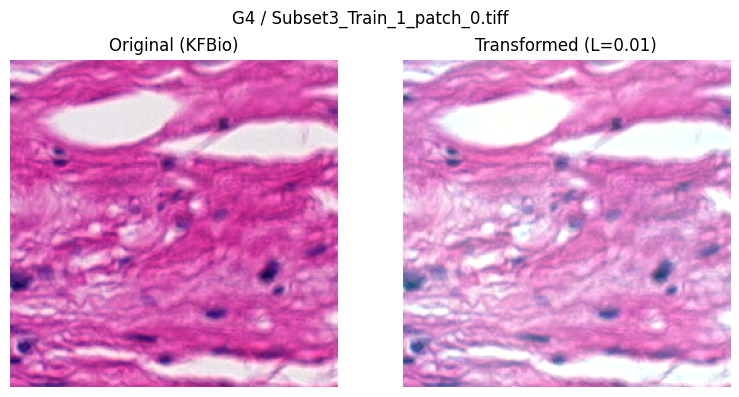

Displayed: Subset3_Train_1_patch_0.tiff


In [ ]:
L_values = ["L_0.01", "L_0.02", "L_0.05", "unmodified"]
labels = ["stroma", "normal", "G3", "G4", "G5"]
for L_tag in L_values:
    print(f"--- {L_tag} ---")
    total = 0
    for label in labels:
        folder = os.path.join(output_root, L_tag, label)
        if not os.path.exists(folder):
            print(f"  ⚠️  Missing folder: {folder}")
            continue
        tiff_files = [f for f in os.listdir(folder) if f.endswith(".tiff")]
        print(f"  {label}: {len(tiff_files)} images")
        total += len(tiff_files)

    print(f"  ✅ Total in {L_tag}: {total} images\n")

#MODIFY THIS FOR FULL RANDOMISATION, maybe do a loop for ten patches

# Path to your transformed data
output_root = "/home/leolr-int/transformed_data/KFBio"
example_folder = os.path.join(output_root, "L_0.01", "G4")

# Show example image using matplotlib (Jupyter-friendly)
output_root = "/home/leolr-int/transformed_data/KFBio"
transformed_folder = os.path.join(output_root, "L_0.01", "G4")
unmodified_folder = os.path.join(output_root, "unmodified", "G4")

# Show example transformed vs original
show_example = True
if show_example:
    if os.path.exists(transformed_folder) and os.path.exists(unmodified_folder):
        files = [f for f in os.listdir(transformed_folder) if f.endswith(".tiff")]
        if files:
            filename = random.choice(files)

            # Load transformed and unmodified
            transformed_path = os.path.join(transformed_folder, filename)
            unmodified_path = os.path.join(unmodified_folder, filename)

            if not os.path.exists(unmodified_path):
                print(f"⚠️ Matching unmodified file not found: {unmodified_path}")
            else:
                img_transformed = Image.open(transformed_path)
                img_unmodified = Image.open(unmodified_path)

                # Plot side by side
                fig, axs = plt.subplots(1, 2, figsize=(8, 4))
                axs[0].imshow(img_unmodified)
                axs[0].set_title("Original (KFBio)")
                axs[0].axis('off')

                axs[1].imshow(img_transformed)
                axs[1].set_title("Transformed (L=0.01)")
                axs[1].axis('off')

                plt.suptitle(f"G4 / {filename}", fontsize=12)
                plt.tight_layout()
                plt.show()

                print(f"Displayed: {filename}")
        else:
            print("⚠️ No images found in transformed folder.")
    else:
        print(f"⚠️ One of the folders does not exist:\n  {transformed_folder}\n  {unmodified_folder}")